In [1]:
### Import packages

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette("Dark2")

from learnspec.functions import directories, stacking

import pandas as pd

### For ML
import tensorflow as tf
from tensorflow.keras import layers, Model


plt.style.use('/Users/aayushsaxena/Desktop/Oxford/plt_styles/as_jades.mplstyle')


In [2]:
### List of all input redshift catalogues
all_redshifts = ["/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-DEEP/visual_inspection_hst_gs_deep_v0.7.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-1287/visual_redshifts_consolidated_1287_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-3215/visual_redshifts_consolidated_ultra_deep_gs_3215_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-MEDIUM/visual_redshifts_hst_medium_redo_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1180/visual_redshifts_JWST_Medium_1180_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1286/visual_redshifts_1286_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-HST-MEDIUM/visual_redshifts_consolidated_gn_hst_medium_1181_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-JWST-MEDIUM/visual_redshifts_consolidated_gn_jwst_medium_1181_v0.6.csv"]

all_surveys = ['GS-HST-DEEP', 'GS-JWST-DEEP', 'GS-3215', 'GS-HST-MEDIUM', 'GS-JWST-MEDIUM-1180', 'GS-JWST-MEDIUM-1286', 'GN-HST-MEDIUM', 'GN-JWST-MEDIUM']

# Pre-processing of the data

In [3]:
### It is possible to load in multiple redshift catalogues and combine them
### This is useful if you want to stack sources from multiple surveys
grating = "prism"

speclist = []
redshifts = []
for i in range(len(all_redshifts)):
    input_cat = pd.read_csv(all_redshifts[i])
    survey = all_surveys[i]
    redshift_range = (6,15)
    specdir, version = directories.translate_dir(survey, grating)
    speclist_temp, redshifts_temp = directories.select_sources(input_cat, specdir, redshift_range, grating, version)
    speclist.extend(speclist_temp)
    redshifts.extend(redshifts_temp)

redshifts = np.array(redshifts, dtype=float)
total_sources = len(speclist)
print(f"Number of sources with z > {redshift_range[0]} and z < {redshift_range[1]}: {total_sources}")

Number of sources with z > 6 and z < 15: 221


In [6]:
# First step is to de-redshift, renormalize and resample all the spectra on to a common wavelength grid
# The renormalization for the majority of the spectra is done such that the flux at 1500A rest frame is set to 1
# For grating spectra, currently no renormalization is done
# Pick the desired resolution of the final stack
resolution = 3.0

if grating == 'prism':
    mean_stack, median_stack, std_stack, resampled_spec = stacking.sigma_clipped_stacking(speclist, redshifts, resolution=resolution, sigma=100.0)
    # mean_stack, resampled_spec = stacking.mean_stacking(speclist, redshifts, resolution=resolution)
else:
    mean_stack, median_stack, std_stack, resampled_spec = stacking.stack_grating(speclist, redshifts, grating=grating, resolution=resolution)


print("Spectra de-redshifted, renormalized and resampled")
print("Mean stack shape: ", mean_stack.shape)
print("Median redshift: ", np.median(redshifts))


/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))
/Users/aayushsaxena/Desktop/

Spectra de-redshifted, renormalized and resampled
Mean stack shape:  (1978,)
Median redshift:  7.08972


/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:1068: RuntimeWarning: Mean of empty slice
  return nanmean(self.data, axis=self.axis)
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:1081: RuntimeWarning: All-NaN slice encountered
  return nanmedian(self.data, axis=self.axis)
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


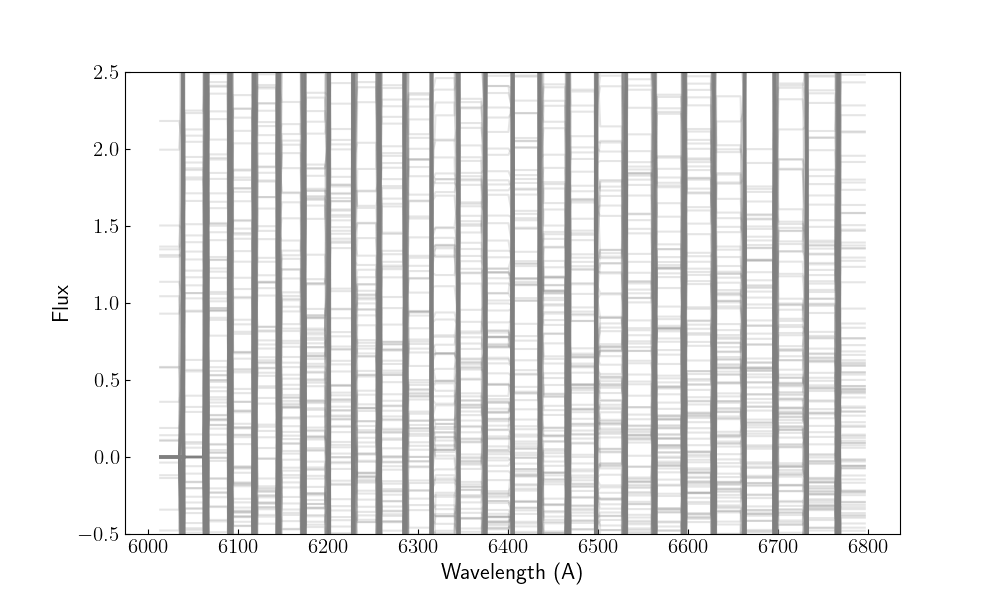

In [7]:
### Plot resampled spectra
plt.figure(figsize=(10, 6))
for i in range(len(resampled_spec)):
    plt.plot(resampled_spec[i].spectral_axis, resampled_spec[i].data, alpha=0.2, color='grey')


plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.ylim(-0.5, 2.5)
plt.show()

## Dimensionality reduction and clustering analysis on resampled spectra

### Pre-processing the data

In [90]:
### Load resampled spectra
resampled_data = np.load("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/data/z4-16/resampled_spectra_z4-16.npy")
### Load the wavelength grid
wavelength = np.load("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/data/z4-16/resampled_wavelength_z4-16.npy")
### Load the redshift information
redshifts = np.load("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/data/z4-16/redshift_info_z4-16.npy")

In [91]:
### Let's remove NaN values from the spectra by setting them to 0
for i in range(len(resampled_data)):
    resampled_data[i][np.isnan(resampled_data[i])] = 0.0
    resampled_data[i][np.isinf(resampled_data[i])] = 0.0

### First only extract the data from the resampled spectra
# resampled_data = np.array([spec.data for spec in resampled_spec])

### Extract the wavelength axis from the first spectrum
# wavelength = resampled_spec[0].spectral_axis.value

### Furthermore, let's minmax normalize the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### Also try and standardize the data instead
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### To preserve the emission line features, we can also use the RobustScaler
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### Implement arcsinh transformation, which is good for spectra that have strong emission lines
from sklearn.preprocessing import FunctionTransformer
arcsinh_transformer = FunctionTransformer(np.arcsinh, validate=True)
resampled_data = arcsinh_transformer.fit_transform(resampled_data)

### Save the transformed data for later use
# np.save("../data/resampled_data_z4_16_res2.npy", resampled_data)
# ## Save the corresponding wavelength axis
# np.save("../data/wavelength_z4_16_res2.npy", resampled_spec[0].spectral_axis.value)
# ## Save the redshift values
# np.save("../data/redshift_z4_16_res2.npy", redshifts)

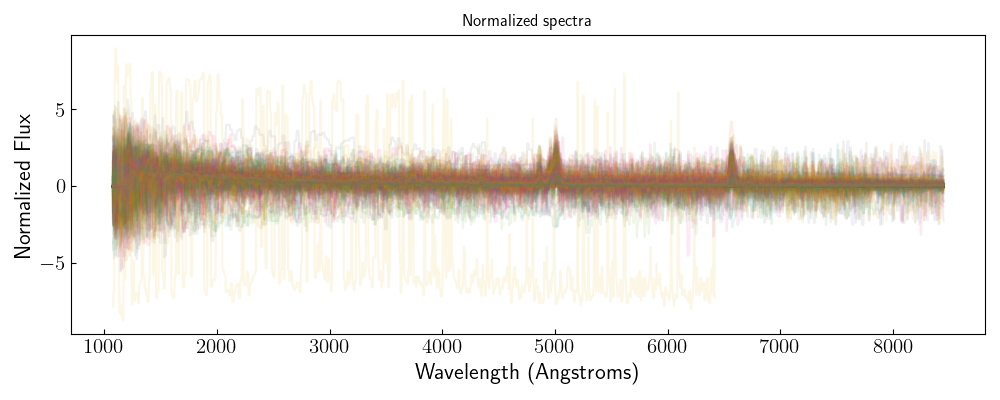

In [92]:
### Plot the normalized data
plt.close()
plt.figure(figsize=(10,4))
plt.plot(wavelength, resampled_data.T, alpha=0.1)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Normalized Flux")
plt.title("Normalized spectra")
plt.tight_layout()
plt.show()

In [15]:
### Print the summary statistics of the data
print(np.min(resampled_data), np.max(resampled_data), np.mean(resampled_data), np.std(resampled_data))

-8.73882450540276 8.959384302773309 0.22975419098401628 0.47994667704093263


In [76]:
### Prepare the data for the VAE
# Set input dimensions
input_dim = len(resampled_data[0])  # Change this to your spectral length
print(f"Input dimension: {input_dim}")
latent_dim = 16  # Change this to your desired latent dimension

Input dimension: 2459


In [77]:
# === Encoder ===
inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === Decoder ===
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)  # use linear activation for reconstruction

decoder = Model(latent_inputs, outputs, name="decoder")

# === Custom VAE Model ===
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # === Masking regions where data == 0 (i.e., formerly NaN) ===
            mask = tf.cast(tf.not_equal(data, 0.0), tf.float32)
            diff = mask * (data - reconstruction)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(diff), axis=1))

            # KL divergence (safe)
            z_log_var_clipped = tf.clip_by_value(z_log_var, -10.0, 10.0)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var_clipped - tf.square(z_mean) - tf.exp(z_log_var_clipped), axis=1
            ))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

# === Compile and Train ===
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


In [93]:
### Training the model
vae.fit(resampled_data, epochs=500, batch_size=128, shuffle=True)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 22.8500 - loss: 147.8345 - reconstruction_loss: 124.9845
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 21.3753 - loss: 151.5638 - reconstruction_loss: 130.1885
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 22.8968 - loss: 144.1068 - reconstruction_loss: 121.2100
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 24.2406 - loss: 151.9395 - reconstruction_loss: 127.6990
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 22.8777 - loss: 150.6598 - reconstruction_loss: 127.7821
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 23.1110 - loss: 146.8582 - reconstruction_loss: 123.7471
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 22.1950 - loss: 149.2345 - reconstruction_loss: 127.0395
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 23.1496 - loss: 150.4149 - reconstruction_loss: 127.2653
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_l

In [22]:
### Save the full model in keras format
vae.save("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/models/jades_z4_16_res3_vae_model_full.keras")  # TensorFlow's recommended format
### Save the model in hdf5 format
# vae.save("../model/jades_z4_16_res3_vae_model_full.h5")  # HDF5 format

### Load the model
from tensorflow.keras.models import load_model
# vae = tf.keras.models.load_model("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/models/jades_z4_16_res3_vae_model_full.keras", 
#                                  custom_objects={'VAE': VAE, 'sampling': sampling})
### Load the model
# vae = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_model_full.h5", custom_objects={'sampling': sampling})


In [ ]:
### Save the encoder and decoder separately
encoder.save("../models/jades_z4_16_res3_vae_encoder.keras")
decoder.save("../models/jades_z4_16_res3_vae_decoder.keras")
### Load the encoder and decoder separately
# encoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_encoder.keras", custom_objects={'sampling': sampling})
# decoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_decoder.keras", custom_objects={'sampling': sampling})

### Save the encoder and decoder separately in hdf5 format
# encoder.save("../models/jades_z4_16_res3_vae_encoder.h5")
# decoder.save("../models/jades_z4_16_res3_vae_decoder.h5")
### Load the encoder and decoder separately in hdf5 format
# encoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_encoder.h5", custom_objects={'sampling': sampling})
# decoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_decoder.h5", custom_objects={'sampling': sampling})

In [ ]:
### Save the model weights
vae.build(input_shape=(None, input_dim))
vae.save_weights("jades_z4_16_res3_vae_model.weights.h5")
### Load the model weights
# vae.load_weights("../model/jades_z4_16_res3_vae_model.weights.h5")

In [ ]:
### Plot the training history
history = vae.history.history
plt.close()
plt.figure(figsize=(10,4))
plt.plot(history['loss'], label='Total Loss')
plt.plot(history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history['kl_loss'], label='KL Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training History")
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
### Extract the latent space representation
z_mean, z_log_var, z = encoder.predict(resampled_data)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


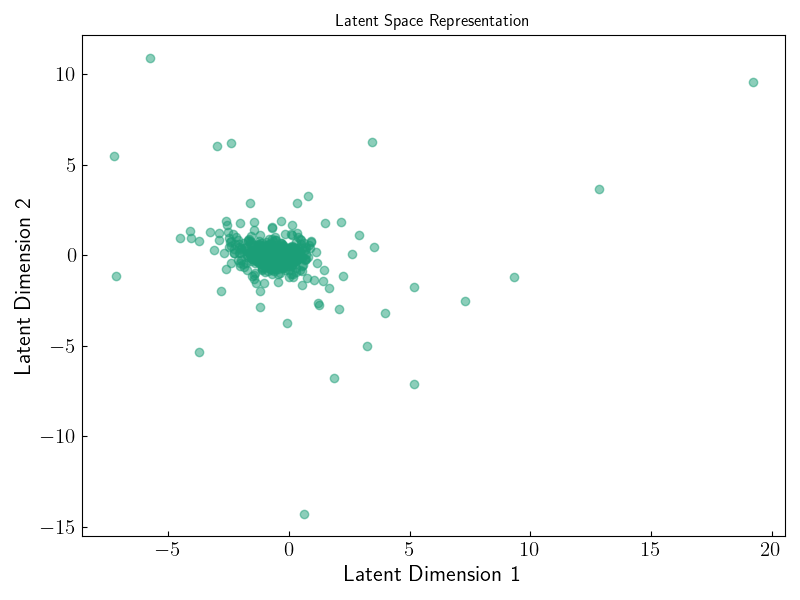

In [94]:
### Visualize the latent space
plt.close()
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Representation")
plt.tight_layout()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


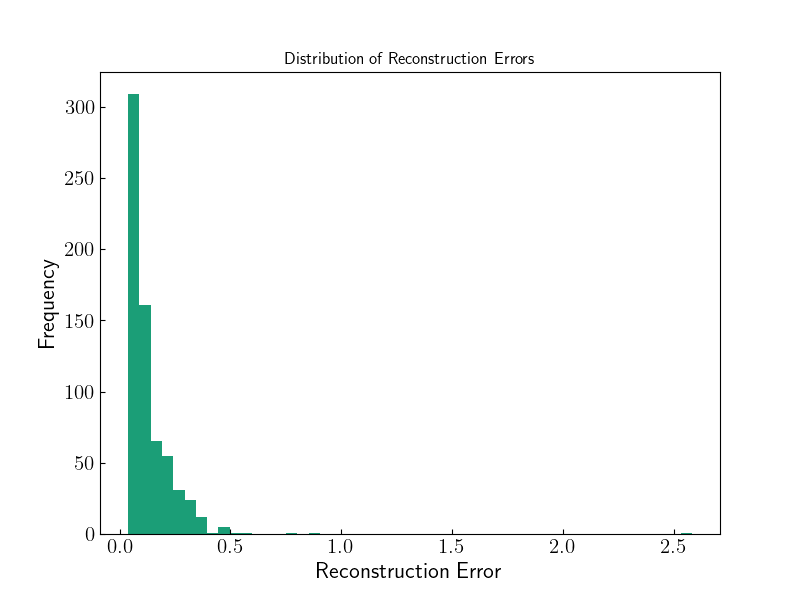

In [95]:
### Reconstruction errors
# Compute reconstruction errors
reconstructed_spectra = vae.decoder.predict(z_mean)
reconstruction_errors = np.mean(np.abs(resampled_data - reconstructed_spectra), axis=1)

# Plot reconstruction errors
plt.close()
plt.figure(figsize=(8, 6))
plt.hist(reconstruction_errors, bins=50)
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


Sample index: 478
Reconstruction error: 0.3815251829460883


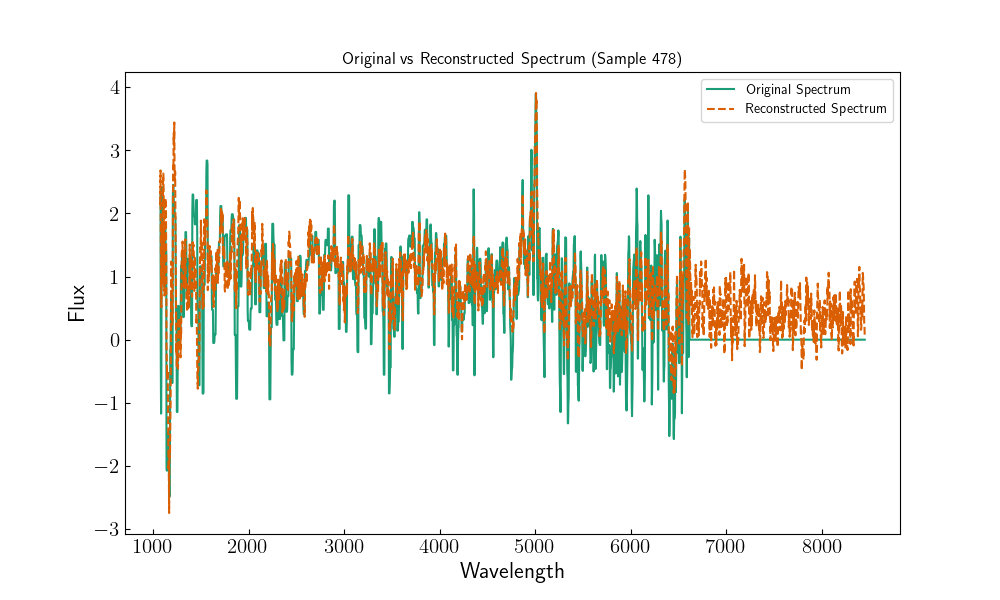

In [112]:
### Visualize specific spectra
# Select a random sample from the data
sample_idx = np.random.randint(len(resampled_data))

# Visualise the source with the second highest reconstruction error
# sample_idx = np.argmax(reconstruction_errors)
sample_idx = np.argsort(reconstruction_errors)[-13]

### POick the sample spectrum and its corresponding reconstructed spectrum
sample_spectrum = resampled_data[sample_idx]
reconstructed_spectrum = reconstructed_spectra[sample_idx]
print(f"Sample index: {sample_idx}")
print(f"Reconstruction error: {reconstruction_errors[sample_idx]}")

# Plot original vs reconstructed spectrum
plt.close()
plt.figure(figsize=(10, 6))
plt.plot(wavelength, sample_spectrum, label="Original Spectrum")
plt.plot(wavelength, reconstructed_spectrum, label="Reconstructed Spectrum", linestyle="--")
plt.title(f"Original vs Reconstructed Spectrum (Sample {sample_idx})")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [118]:
### Perform clustering in latent space
# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
# cluster_labels = clusterer.fit_predict(z_mean)  # shape (n_samples, 16)

### Use GMM
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
cluster_labels = gmm.fit_predict(z_mean)

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


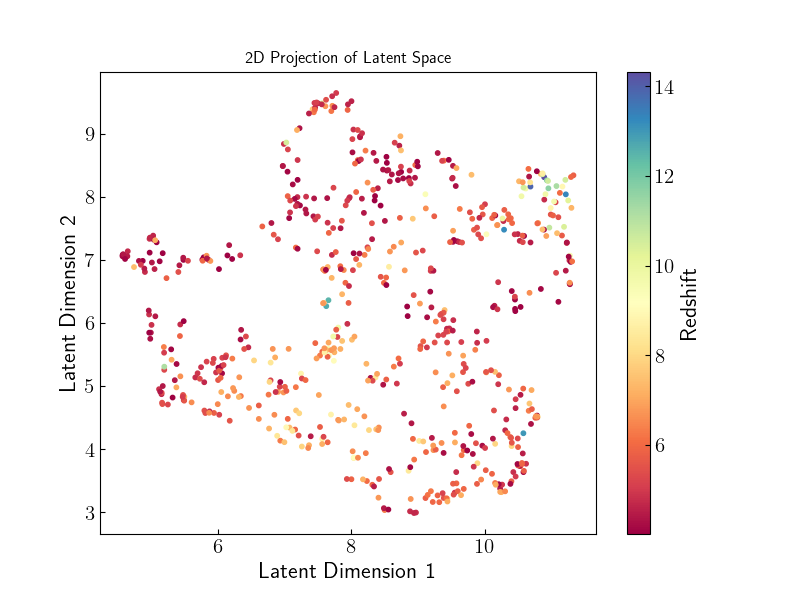

In [121]:
# Use UMAP to reduce the latent space to 2D
import umap
umap_model = umap.UMAP(n_neighbors=10, min_dist=0., metric='euclidean')
z_2d = umap_model.fit_transform(z_mean)

# Plot the 2D latent space
plt.close()
plt.figure(figsize=(8, 6))
# plt.scatter(z_2d[:, 0], z_2d[:, 1], c=np.arange(len(z_2d)), cmap='Spectral', s=10)
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=redshifts, cmap='Spectral', s=10)
plt.colorbar(label="Redshift")
plt.title("2D Projection of Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


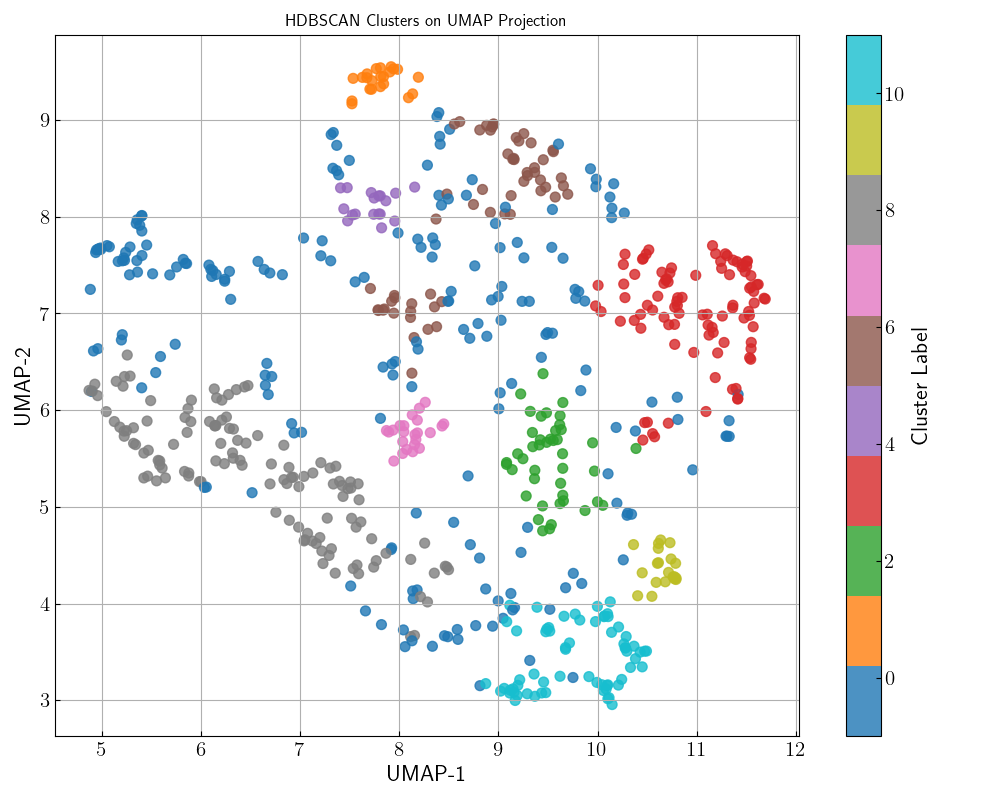

In [130]:
### Let's perfomr some clustering on the UMAP output using HDBSCAN
import hdbscan

# umap_embedding: shape (n_samples, 2), from earlier
umap_embedding = umap_model.fit_transform(z_mean)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric='euclidean')
cluster_labels = clusterer.fit_predict(umap_embedding)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],
            c=cluster_labels, cmap='tab10', s=50, alpha=0.8)
plt.title('HDBSCAN Clusters on UMAP Projection')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()

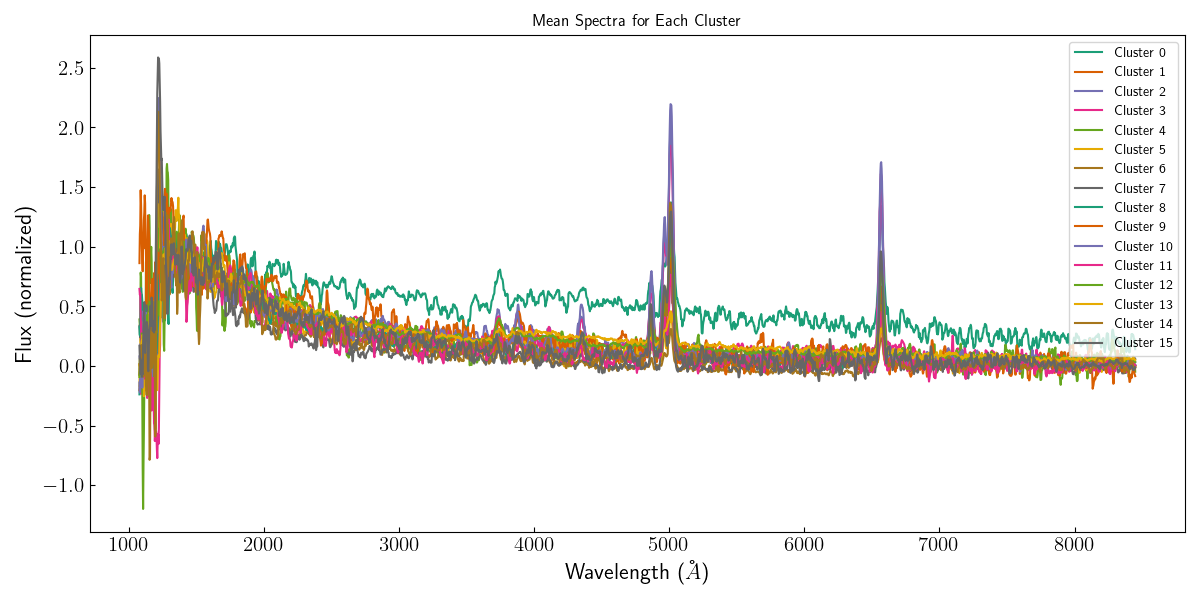

In [128]:
### Let's produce a mean spectrum per cluster
unique_labels = np.unique(cluster_labels)
n_clusters = len(unique_labels[unique_labels != -1])  # excluding noise if any

plt.close()
plt.figure(figsize=(12, 6))

for i, label in enumerate(unique_labels):
    if label == -1:
        continue  # skip noise
    cluster_spectra = resampled_data[cluster_labels == label]
    mean_spectrum = np.mean(cluster_spectra, axis=0)
    plt.plot(wavelength, mean_spectrum, label=f'Cluster {label}')

plt.title("Mean Spectra for Each Cluster")
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux (normalized)")
# plt.ylim(-10,10)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/sv/jx060lhd70z6wbjpbh0tbbrr0000gt/T/ipykernel_4493/3115462914.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(z_vals, label=f"Cluster {label}")


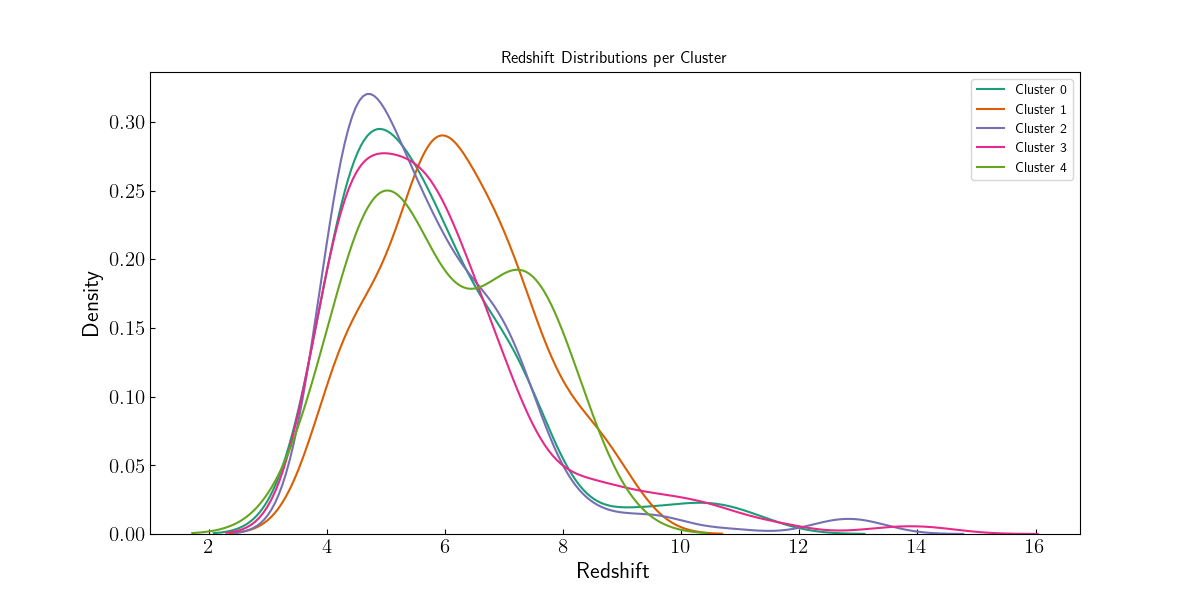

In [59]:
### Redshift distribution per cluster
plt.close()
plt.figure(figsize=(12, 6))
for label in unique_labels:
    if label == -1:
        continue
    z_vals = redshifts[cluster_labels == label]
    sns.kdeplot(z_vals, label=f"Cluster {label}")

plt.title("Redshift Distributions per Cluster")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend()
plt.show()